## Simulate some relfected light planets

In [1]:
from psisim import telescope,instrument,observation,spectrum,universe,plots
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import copy
import time
from astropy.io import fits

/Users/sofiahillman/opt/anaconda3/lib/python3.8/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/sofiahillman/opt/anaconda3/lib/python3.8/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


Tried importing picaso, but couldn't do it


### Set up the telescope and instrument configuration

In [2]:
tmt = telescope.TMT()
psi_blue = instrument.PSI_Blue()
psi_blue.set_observing_mode(3600,10,'z',50, np.linspace(0.60,0.85,40)) #60s, 40 exposures,z-band, R of 10

### Generate planets and host stars with EXOSIMS

We will make some cuts to limit to realistically detected planets.

The planet table has all the planet and host star properties, which we will use going forward

In [3]:
exosims_config_filename = "forBruceandDimitri_EXOCAT1.json" #Some filename here
uni = universe.ExoSims_Universe(exosims_config_filename)
uni.simulate_EXOSIMS_Universe()

planet_table = uni.planets
full_planet_table = copy.deepcopy(uni.planets)
#Down select the planets whose separations are less than lambda/D
min_iwa = np.min(psi_blue.current_wvs)*1e-6/tmt.diameter*206265
planet_table = planet_table[planet_table['AngSep'].to(u.arcsec).value > min_iwa]
planet_table = planet_table[planet_table['Flux Ratio'] > 1e-10] # this is a rough planet contrast estimated by EXOSIMS
n_planets = len(planet_table)

Imported SurveySimulation (prototype module) from EXOSIMS.Prototypes.SurveySimulation
Numpy random seed is: 688223635
Imported SAG13Universe (specific module) from EXOSIMS.SimulatedUniverse.SAG13Universe
Imported TargetList (prototype module) from EXOSIMS.Prototypes.TargetList
Imported EXOCAT1 (specific module) from EXOSIMS.StarCatalog.EXOCAT1
Imported Nemati (specific module) from EXOSIMS.OpticalSystem.Nemati
Imported Stark (specific module) from EXOSIMS.ZodiacalLight.Stark
Imported PostProcessing (prototype module) from EXOSIMS.Prototypes.PostProcessing
Imported BackgroundSources (prototype module) from EXOSIMS.Prototypes.BackgroundSources
Imported Completeness (prototype module) from EXOSIMS.Prototypes.Completeness
Imported SAG13 (specific module) from EXOSIMS.PlanetPopulation.SAG13
Imported Forecaster (specific module) from EXOSIMS.PlanetPhysicalModel.Forecaster
2396 targets imported from star catalog.
2138 targets remain after nan filtering.
1977 targets remain after binary filter

### We'll pick random planets, since many systems are multi-planet systems and they show up  sequentially in EXOSIMS

This example will only generate 2 planets for speed

In [4]:
planet_types = []
planet_spectra = []

n_planets_now = 2 # how many 

rand_planets = np.random.randint(0, n_planets, n_planets_now)


## Model spectrum wavelength choice based on instrument setup

In [5]:

# We're going to generate a model spectrum at a resolution twice the 
# requested resolution
intermediate_R = psi_blue.current_R*2
#Choose the model wavelength range to be just a little bigger than 
#the observation wavelengths
model_wv_low = 0.9*np.min(psi_blue.current_wvs) 
model_wv_high = 1.1*np.max(psi_blue.current_wvs)

#Figure out a good wavelength spacing for the model
wv_c = 0.5*(model_wv_low+model_wv_high) #Central wavelength of the model
dwv_c = wv_c/intermediate_R #The delta_lambda at the central wavelength
#The number of wavelengths to generate. Divide by two for nyquist in the d_wv. 
#Multiply the final number by 2 just to be safe.
n_model_wv = int((model_wv_high-model_wv_low)/(dwv_c/2))*2
#Generate the model wavelenths
model_wvs = np.linspace(model_wv_low, model_wv_high, n_model_wv) #Choose some wavelengths

## Generate spectra using PICASO

We will use a simple cloudy Jupiter model right now. More advanced models will be coming very soon. 

In [6]:
print("\n Starting to generate planet spectra")
for planet in planet_table[rand_planets]:

    #INSERT PLANET SELECTION RULES HERE
    planet_type = "Gas"
    planet_types.append(planet_type)

    time1 = time.time()
    #Generate the spectrum and downsample to intermediate resolution
    atmospheric_parameters = spectrum.generate_picaso_inputs(planet,planet_type, clouds=True)
    planet_spectrum = spectrum.simulate_spectrum(planet, model_wvs, intermediate_R, atmospheric_parameters)
    planet_spectra.append(planet_spectrum)
    
    time2 = time.time()
    print('Spectrum took {0:.3f} s'.format((time2-time1)))

print("Done generating planet spectra")


 Starting to generate planet spectra
Spectrum took 8.193 s
Spectrum took 8.196 s
Done generating planet spectra


## Simulate the observations and calculate the SNR of the observation

In [1]:
print("\n Starting to simulate observations")

planet_spectra = np.array(planet_spectra)

post_processing_gain=1000
sim_F_lambda, sim_F_lambda_errs,sim_F_lambda_stellar, noise_components = observation.simulate_observation_set(tmt, psi_blue,
    planet_table[rand_planets], planet_spectra, model_wvs, intermediate_R, inject_noise=False,
    post_processing_gain=post_processing_gain,return_noise_components=True)


speckle_noises = noise_components[:,0,:]
photon_noises = noise_components[:,3,:]

flux_ratios = sim_F_lambda/sim_F_lambda_stellar
detection_limits = sim_F_lambda_errs/sim_F_lambda_stellar
snrs = sim_F_lambda/sim_F_lambda_errs

detected = psi_blue.detect_planets(planet_table[rand_planets],snrs,tmt)



 Starting to simulate observations


NameError: name 'np' is not defined

## Plot the Planets.

This will be sparse since we only have 2 planets

Text(0.04, 2.5e-06, 'Post-processing gain: 1000')

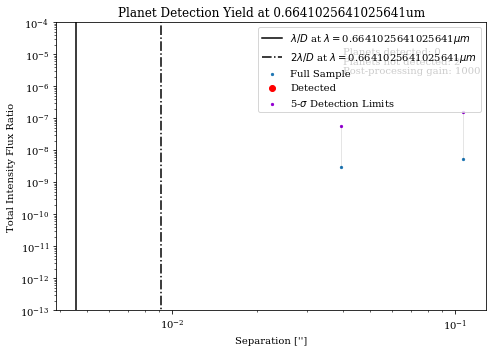

In [8]:
#Choose which wavelength you want to plot the detections at:
wv_index = 10
fig, ax = plots.plot_detected_planet_contrasts(planet_table[rand_planets],wv_index,
    detected,flux_ratios,psi_blue,tmt,ymin=1e-13,alt_data=5*detection_limits,alt_label=r"5-$\sigma$ Detection Limits", show=False)

#The user can now adjust the plot as they see fit. 
#e.g. Annotate the plot
ax.text(4e-2,1e-5,"Planets detected: {}".format(len(np.where(detected[:,wv_index])[0])),color='k')
ax.text(4e-2,0.5e-5,"Planets not detected: {}".format(len(np.where(~detected[:,wv_index])[0])),color='k')
ax.text(4e-2,0.25e-5,"Post-processing gain: {}".format(post_processing_gain),color='k')


### Save things

In [9]:
######################## Save things ######################
planet_table.write("planet_table.ecsv",format='ascii.ecsv')
ps_hdu = fits.PrimaryHDU(planet_spectra)
ps_hdu.writeto("planet_spectra.fits",overwrite=True)
flux_hdu = fits.PrimaryHDU([sim_F_lambda, sim_F_lambda_errs,np.array(sim_F_lambda_stellar)])
flux_hdu.writeto("Observation_set.fits",overwrite=True)
noise_components_hdu = fits.PrimaryHDU(noise_components)
noise_components_hdu.writeto("noise_components.fits",overwrite=True)

# #HOWTO: Read things back in
# from astropy.io import ascii
# planet_table = ascii.read("planet_table.ecsv",format='ascii.ecsv')
# planet_spectra = fits.open("planet_spectra.fits")[0].data
# tmp = fits.open("Observation_set.fits")[0].data
# sim_F_lambda = tmp[0]
# sim_F_lambda_errs = tmp[1]
# sim_F_lambda_stellar = tmp[2]
# noise_components = fits.open("noise_components.fits")[0].data

## Plot a simulated spectrum and compare cloudy vs clear atmospheres

[0.20254225 0.3045518 ]


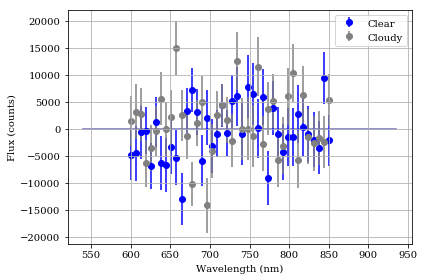

In [10]:
######################## Plot Cloud vs. Clear ######################


# get the best SNR Planet
avg_snrs = np.mean(snrs, axis=1)
print(avg_snrs)
argsort_snrs = np.argsort(np.abs(avg_snrs - 6))
bestsnr = argsort_snrs[0] #np.argmax(avg_snrs)

# Generate the cloudy spectrum of this planet
planet = planet_table[rand_planets[bestsnr]]
atmospheric_parameters_clear = spectrum.generate_picaso_inputs(planet, planet_type, clouds=False)
planet_spectrum_clear = spectrum.simulate_spectrum(planet, model_wvs, intermediate_R, atmospheric_parameters_clear)

# Generate noisy spectra for cloudy and clear
clear_F_lambda, clear_F_lambda_errs, _ = observation.simulate_observation(tmt, psi_blue,
   planet_table[rand_planets[bestsnr]], planet_spectrum_clear, model_wvs, intermediate_R, inject_noise=True,post_processing_gain=post_processing_gain)
cloudy_F_lambda, cloudy_F_lambda_errs, _ = observation.simulate_observation(tmt, psi_blue,
   planet_table[rand_planets[bestsnr]], planet_spectra[bestsnr], model_wvs, intermediate_R, inject_noise=True,post_processing_gain=post_processing_gain)

fig = plt.figure()

plt.errorbar(psi_blue.current_wvs*1000, clear_F_lambda, yerr=clear_F_lambda_errs, color='Blue', marker='o', linestyle='none', label="Clear", zorder=1)
plt.errorbar(psi_blue.current_wvs*1000, cloudy_F_lambda, yerr=cloudy_F_lambda_errs, color='Gray', marker='o', linestyle='none', label="Cloudy", zorder=1)


plt.grid()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Flux (counts)")
plt.legend()
plt.tight_layout()

plt.show()